In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from pathlib import Path

In [ ]:
root_dir = Path('../../data/MBTA_Bus_Arrival_Departure_Times')
output_dir = Path('../../data/MBTA_Bus_Parquet')
output_dir.mkdir(exist_ok=True)

years = [d.name for d in root_dir.iterdir() if d.is_dir()]

for year in years:
    print(f"Converting {year}...")
    year_folder = root_dir / year
    all_dfs = []

    for csv_file in year_folder.rglob('*.csv'):
        # Load each CSV with low-memory settings
        df = pd.read_csv(csv_file, low_memory=False)
        all_dfs.append(df)

    year_df = pd.concat(all_dfs, ignore_index=True)

    # Convert obvious text columns to category to reduce file size
    for col in year_df.select_dtypes('object').columns:
        year_df[col] = year_df[col].astype('category')

    # Save to Parquet (columnar + compressed)
    year_df.to_parquet(output_dir / f"{year}.parquet", index=False)

    # Free memory
    del year_df, all_dfs


Converting MBTA_Bus_Arrival_Departure_Times_2018...
Converting MBTA_Bus_Arrival_Departure_Times_2019...
Converting MBTA_Bus_Arrival_Departure_Times_2020...
Converting MBTA_Bus_Arrival_Departure_Times_2021...
Converting MBTA_Bus_Arrival_Departure_Times_2022...
Converting MBTA_Bus_Arrival_Departure_Times_2023...
Converting MBTA_Bus_Arrival_Departure_Times_2024...
Converting MBTA_Bus_Arrival_Departure_Times_2025...


In [ ]:
import dask.dataframe as dd
from pathlib import Path

# Define path and target routes
root_dir = Path("../../data/MBTA_Bus_Parquet")
target_routes = [str(r) for r in [22, 29, 15, 45, 28, 44, 42, 17, 23, 31, 26, 111, 24, 33, 14]]

# Get all parquet files (one per year)
parquet_files = sorted(root_dir.glob("*.parquet"))

In [32]:
def safe_to_datetime(series):
    """Try to convert to datetime safely, handling numeric or string types."""
    if pd.api.types.is_numeric_dtype(series):
        # treat as seconds from midnight if values look small
        return dd.to_datetime(series, unit='s', origin='unix', errors='coerce')
    else:
        return dd.to_datetime(series, errors='coerce')

In [42]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Define function to convert time string to seconds since midnight
def time_to_seconds(t_str):
    if pd.isna(t_str):
        return np.nan
    try:
        dt = datetime.strptime(t_str, '%I:%M %p')
        return dt.hour * 3600 + dt.minute * 60
    except ValueError:
        return np.nan

# List of years
years = range(2018, 2026)

# Target routes as strings
target_routes = ['22', '29', '15', '45', '28', '44', '42', '17', '23', '31', '26', '111', '24', '33', '14']

# Lists to store results for each year
avg_wait_on_time_list = []
avg_wait_delayed_list = []
avg_delay_all_list = []
avg_delay_target_list = []

for year in years:
    # Assume file names are like 'data_YYYY.parquet' - adjust if different
    file_path = f'../../data/MBTA_Bus_Parquet/MBTA_Bus_Arrival_Departure_Times_{year}.parquet'
    print(f"Processing {file_path}...")
    
    # Read the Parquet file
    df = pd.read_parquet(file_path)
    
    # Convert scheduled and actual times to seconds
    df['scheduled_sec'] = df['scheduled'].apply(time_to_seconds)
    df['actual_sec'] = df['actual'].apply(time_to_seconds)
    
    # Compute delay_sec
    df['delay_sec'] = np.nan
    mask_schedule = df['standard_type'] == 'Schedule'
    df.loc[mask_schedule, 'delay_sec'] = df.loc[mask_schedule, 'actual_sec'] - df.loc[mask_schedule, 'scheduled_sec']
    mask_headway = df['standard_type'] == 'Headway'
    df.loc[mask_headway, 'delay_sec'] = df.loc[mask_headway, 'headway'] - df.loc[mask_headway, 'scheduled_headway']
    
    # For question 1: Average wait times (headway standard only, in seconds)
    # On time: delay_sec <= 0, Delayed: delay_sec > 0
    # Average wait = average headway / 2
    on_time_mask = mask_headway & (df['delay_sec'] <= 0)
    delayed_mask = mask_headway & (df['delay_sec'] > 0)
    
    avg_wait_on_time = df.loc[on_time_mask, 'headway'].mean() / 2 if not df.loc[on_time_mask].empty else np.nan
    avg_wait_delayed = df.loc[delayed_mask, 'headway'].mean() / 2 if not df.loc[delayed_mask].empty else np.nan
    
    # For question 2: Average delay time all routes (in seconds)
    avg_delay_all = df['delay_sec'].mean() if not df.empty else np.nan
    
    # For question 3: Average delay time target routes (in seconds)
    target_df = df[df['route_id'].isin(target_routes)]
    avg_delay_target = target_df['delay_sec'].mean() if not target_df.empty else np.nan
    
    # Append to lists
    avg_wait_on_time_list.append(avg_wait_on_time)
    avg_wait_delayed_list.append(avg_wait_delayed)
    avg_delay_all_list.append(avg_delay_all)
    avg_delay_target_list.append(avg_delay_target)
    
    # Print numeric results for this year
    print(f"Year: {year}")
    print(f"Average wait time (on time): {avg_wait_on_time:.2f} seconds" if not np.isnan(avg_wait_on_time) else "Average wait time (on time): N/A")
    print(f"Average wait time (delayed): {avg_wait_delayed:.2f} seconds" if not np.isnan(avg_wait_delayed) else "Average wait time (delayed): N/A")
    print(f"Average delay time all routes: {avg_delay_all:.2f} seconds" if not np.isnan(avg_delay_all) else "Average delay time all routes: N/A")
    print(f"Average delay time target routes: {avg_delay_target:.2f} seconds" if not np.isnan(avg_delay_target) else "Average delay time target routes: N/A")
    print("\n")

# Create results DataFrame
results_df = pd.DataFrame({
    'Year': years,
    'Avg Wait On Time (sec)': avg_wait_on_time_list,
    'Avg Wait Delayed (sec)': avg_wait_delayed_list,
    'Avg Delay All Routes (sec)': avg_delay_all_list,
    'Avg Delay Target Routes (sec)': avg_delay_target_list
})


Processing ../../data/MBTA_Bus_Parquet/MBTA_Bus_Arrival_Departure_Times_2018.parquet...


Year: 2018
Average wait time (on time): 236.56 seconds
Average wait time (delayed): 496.65 seconds
Average delay time all routes: 4.71 seconds
Average delay time target routes: 4.87 seconds


Processing ../../data/MBTA_Bus_Parquet/MBTA_Bus_Arrival_Departure_Times_2019.parquet...
Year: 2019
Average wait time (on time): 241.79 seconds
Average wait time (delayed): 495.17 seconds
Average delay time all routes: 5.11 seconds
Average delay time target routes: 4.76 seconds


Processing ../../data/MBTA_Bus_Parquet/MBTA_Bus_Arrival_Departure_Times_2020.parquet...
Year: 2020
Average wait time (on time): 266.41 seconds
Average wait time (delayed): 475.19 seconds
Average delay time all routes: 3.11 seconds
Average delay time target routes: 1.88 seconds


Processing ../../data/MBTA_Bus_Parquet/MBTA_Bus_Arrival_Departure_Times_2021.parquet...
Year: 2021
Average wait time (on time): 238.90 seconds
Average wait time (delayed): 461.26 seconds
Average delay time all routes: 2.41 seconds
Average delay tim

In [43]:
# Display the results table
print("Summary Table:")
print(results_df)


Summary Table:
   Year  Avg Wait On Time (sec)  Avg Wait Delayed (sec)  \
0  2018              236.561611              496.650459   
1  2019              241.792063              495.167490   
2  2020              266.405565              475.190004   
3  2021              238.897348              461.261639   
4  2022              242.121979              495.809182   
5  2023              248.622373              520.859160   
6  2024              241.560184              526.541782   
7  2025                     NaN                     NaN   

   Avg Delay All Routes (sec)  Avg Delay Target Routes (sec)  
0                    4.711567                       4.874068  
1                    5.105825                       4.763653  
2                    3.114552                       1.877612  
3                    2.406098                       1.698764  
4                    2.820483                       1.337658  
5                    3.387500                       1.111850  
6           

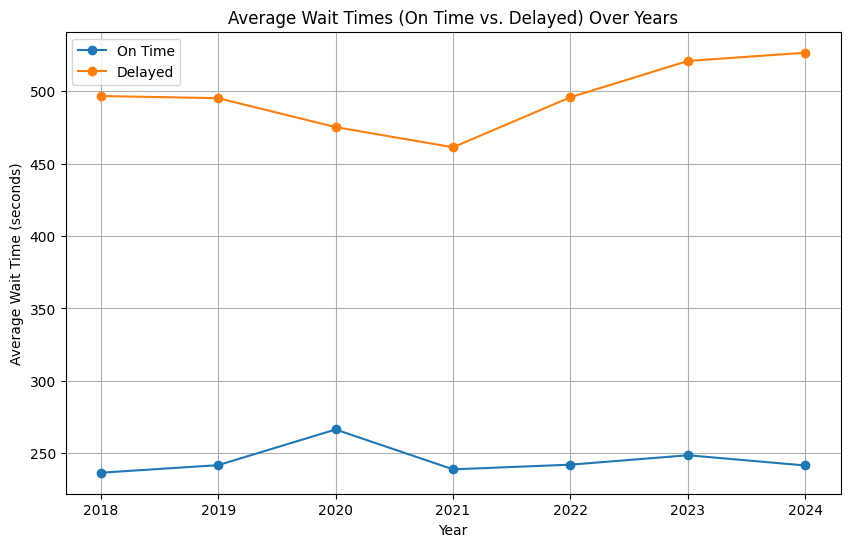

In [44]:
# Visualization 1: Wait times over years
plt.figure(figsize=(10, 6))
plt.plot(results_df['Year'], results_df['Avg Wait On Time (sec)'], label='On Time', marker='o')
plt.plot(results_df['Year'], results_df['Avg Wait Delayed (sec)'], label='Delayed', marker='o')
plt.title('Average Wait Times (On Time vs. Delayed) Over Years')
plt.xlabel('Year')
plt.ylabel('Average Wait Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()



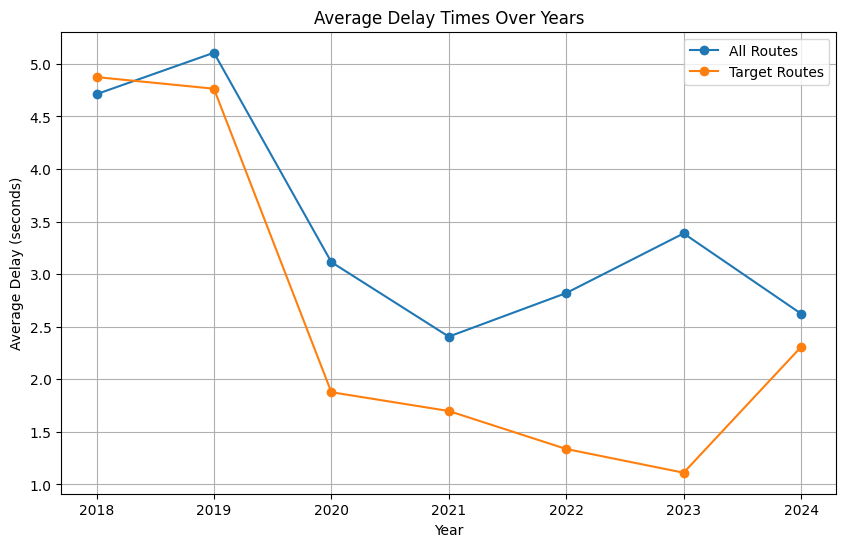

In [45]:
# Visualization 2: Delay times over years
plt.figure(figsize=(10, 6))
plt.plot(results_df['Year'], results_df['Avg Delay All Routes (sec)'], label='All Routes', marker='o')
plt.plot(results_df['Year'], results_df['Avg Delay Target Routes (sec)'], label='Target Routes', marker='o')
plt.title('Average Delay Times Over Years')
plt.xlabel('Year')
plt.ylabel('Average Delay (seconds)')
plt.legend()
plt.grid(True)
plt.show()
